# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
#imports here
import json
import torch
from torchvision import transforms 
from torchvision import models 
from torchvision import datasets
from torch.utils.data import DataLoader

import torch.nn as nn
from torchvision.models import vgg16
from collections import OrderedDict
from torch import optim

import matplotlib.pyplot as plt
import time

from os import listdir
from PIL import Image
import numpy as np

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms_train = transforms.Compose(
    [
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Resize(250),
        transforms.CenterCrop(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
    ]
)

data_transforms_test_validate = transforms.Compose(
    [
        transforms.Resize(250),
        transforms.CenterCrop(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
    ]
)


# TODO: Load the datasets with ImageFolder
image_datasets_train = datasets.ImageFolder(train_dir, transform = data_transforms_train)
image_datasets_validate = datasets.ImageFolder(valid_dir, transform = data_transforms_test_validate)
image_datasets_test = datasets.ImageFolder(test_dir, transform = data_transforms_test_validate)


# TODO: Using the image datasets and the transforms, define the dataloaders
dataloaders_train = DataLoader(image_datasets_train, batch_size = 64, shuffle = True)
dataloaders_validate = DataLoader(image_datasets_validate, batch_size = 64, shuffle = True)
dataloaders_test = DataLoader(image_datasets_test, batch_size = 64, shuffle = True)

In [4]:
# Checking the number of images in the datasets

print("Number of images :")
print("Training Dataset:", len(dataloaders_train.dataset))
print("Validation Dataset:", len(dataloaders_validate.dataset))
print("Test Dataset:", len(dataloaders_test.dataset))

Number of images :
Training Dataset: 6552
Validation Dataset: 818
Test Dataset: 819


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [6]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

<font color='red'>**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.</font>

In [7]:
# TODO: Build and train your network

def pre_trained_model2():
    base_model = vgg16(pretrained = True)
    for parameter in base_model.features:
        parameter.requires_grad = False
    
    #Replacing the classifier while features remain frozen
    base_model.classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 2048)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(2048, 256)),
                          ('relu', nn.ReLU()),
                          ('fc3', nn.Linear(256, 102)),
                          ('output', nn.LogSoftmax(dim = 1))
                          ]))
    base_model = base_model.to('cuda')
    return base_model 

base_model = pre_trained_model2()
print(base_model)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [8]:
def funct_criterion():
    criterion = nn.CrossEntropyLoss()
    return criterion

In [9]:
def funct_optimizer(my_model, alpha = 0.001):
    optimizer = optim.Adam(my_model.classifier.parameters(), alpha)
    return optimizer

In [10]:
base_model = pre_trained_model2()
criterion = funct_criterion()
optimizer = funct_optimizer(base_model, alpha = 0.001)

In [11]:
def check_accuracy(dataloaders):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloaders:
            images, labels = data[0].to('cuda'), data[1].to('cuda')
            outputs = base_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

TRAINING STARTED!!!!
Iteration --> 1/5 
		
Loss :  0.8803	Validation Accuracy :  0.121
		
Loss :  0.7541	Validation Accuracy :  0.2775
		
Loss :  0.5699	Validation Accuracy :  0.3533
		
Loss :  0.5436	Validation Accuracy :  0.3973
		
Loss :  0.4562	Validation Accuracy :  0.5269
		
Loss :  0.3821	Validation Accuracy :  0.5623
		
Loss :  0.3024	Validation Accuracy :  0.6174
		
Loss :  0.2616	Validation Accuracy :  0.6516
		
Loss :  0.3109	Validation Accuracy :  0.6577
		
Loss :  0.1987	Validation Accuracy :  0.6907
		
Loss :  0.3046	Validation Accuracy :  0.7274
		
Loss :  0.2371	Validation Accuracy :  0.7139
		
Loss :  0.116	Validation Accuracy :  0.7103
		
Loss :  0.2239	Validation Accuracy :  0.7702
		
Loss :  0.1742	Validation Accuracy :  0.7677
		
Loss :  0.1949	Validation Accuracy :  0.7311
		
Loss :  0.1292	Validation Accuracy :  0.7751
		
Loss :  0.1567	Validation Accuracy :  0.7971
		
Loss :  0.1563	Validation Accuracy :  0.7848
		
Loss :  0.1571	Validation Accuracy :  0.8032



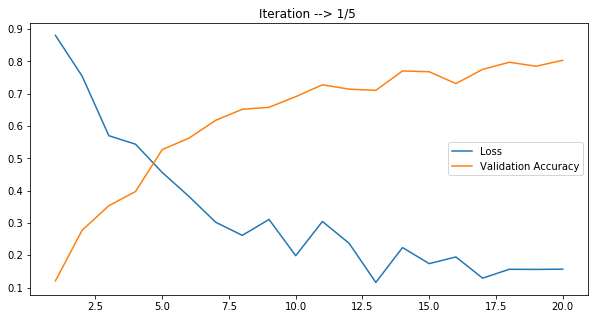

Iteration --> 2/5 
		
Loss :  0.1348	Validation Accuracy :  0.78
		
Loss :  0.1119	Validation Accuracy :  0.7775
		
Loss :  0.104	Validation Accuracy :  0.7726
		
Loss :  0.1707	Validation Accuracy :  0.8154
		
Loss :  0.0656	Validation Accuracy :  0.7836
		
Loss :  0.1669	Validation Accuracy :  0.7885
		
Loss :  0.1107	Validation Accuracy :  0.7995
		
Loss :  0.1261	Validation Accuracy :  0.8154
		
Loss :  0.1304	Validation Accuracy :  0.813
		
Loss :  0.1451	Validation Accuracy :  0.8056
		
Loss :  0.0855	Validation Accuracy :  0.8032
		
Loss :  0.0935	Validation Accuracy :  0.8081
		
Loss :  0.1292	Validation Accuracy :  0.813
		
Loss :  0.0834	Validation Accuracy :  0.8252
		
Loss :  0.0858	Validation Accuracy :  0.8252
		
Loss :  0.0964	Validation Accuracy :  0.8252
		
Loss :  0.0883	Validation Accuracy :  0.8264
		
Loss :  0.1256	Validation Accuracy :  0.8215
		
Loss :  0.1129	Validation Accuracy :  0.8154
		
Loss :  0.164	Validation Accuracy :  0.813
		
Loss :  0.0854	Validation

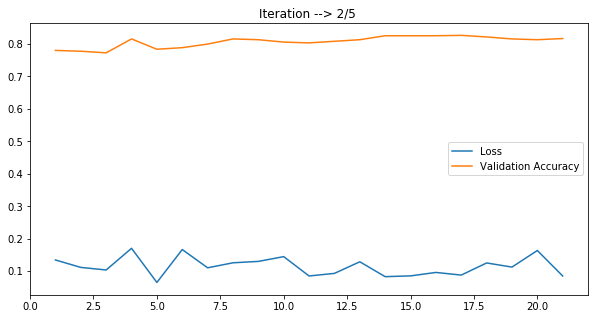

Iteration --> 3/5 
		
Loss :  0.0789	Validation Accuracy :  0.8215
		
Loss :  0.0982	Validation Accuracy :  0.8325
		
Loss :  0.0978	Validation Accuracy :  0.8435
		
Loss :  0.0777	Validation Accuracy :  0.8215
		
Loss :  0.0454	Validation Accuracy :  0.8509
		
Loss :  0.1096	Validation Accuracy :  0.8472
		
Loss :  0.1008	Validation Accuracy :  0.8386
		
Loss :  0.0532	Validation Accuracy :  0.8423
		
Loss :  0.0587	Validation Accuracy :  0.8399
		
Loss :  0.1055	Validation Accuracy :  0.8704
		
Loss :  0.0898	Validation Accuracy :  0.8545
		
Loss :  0.136	Validation Accuracy :  0.8619
		
Loss :  0.0839	Validation Accuracy :  0.8631
		
Loss :  0.1287	Validation Accuracy :  0.8484
		
Loss :  0.0761	Validation Accuracy :  0.8594
		
Loss :  0.0693	Validation Accuracy :  0.8447
		
Loss :  0.1031	Validation Accuracy :  0.8509
		
Loss :  0.0388	Validation Accuracy :  0.8509
		
Loss :  0.068	Validation Accuracy :  0.8313
		
Loss :  0.1037	Validation Accuracy :  0.8521



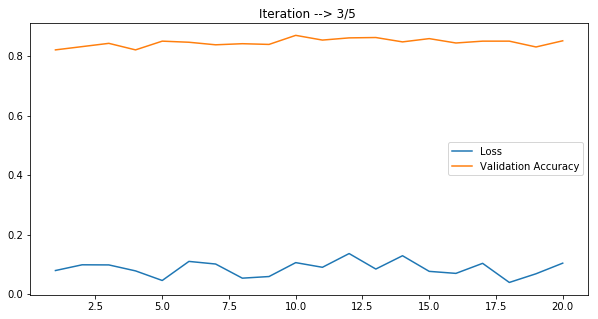

Iteration --> 4/5 
		
Loss :  0.0752	Validation Accuracy :  0.8399
		
Loss :  0.0506	Validation Accuracy :  0.8435
		
Loss :  0.048	Validation Accuracy :  0.8594
		
Loss :  0.0283	Validation Accuracy :  0.8606
		
Loss :  0.0656	Validation Accuracy :  0.8582
		
Loss :  0.0324	Validation Accuracy :  0.8619
		
Loss :  0.058	Validation Accuracy :  0.8594
		
Loss :  0.0534	Validation Accuracy :  0.8411
		
Loss :  0.0877	Validation Accuracy :  0.8423
		
Loss :  0.0452	Validation Accuracy :  0.857
		
Loss :  0.0646	Validation Accuracy :  0.8557
		
Loss :  0.072	Validation Accuracy :  0.8203
		
Loss :  0.0405	Validation Accuracy :  0.8545
		
Loss :  0.0576	Validation Accuracy :  0.835
		
Loss :  0.0376	Validation Accuracy :  0.8594
		
Loss :  0.042	Validation Accuracy :  0.8362
		
Loss :  0.0578	Validation Accuracy :  0.8362
		
Loss :  0.088	Validation Accuracy :  0.8362
		
Loss :  0.0819	Validation Accuracy :  0.8484
		
Loss :  0.0328	Validation Accuracy :  0.8313
		
Loss :  0.0831	Validation

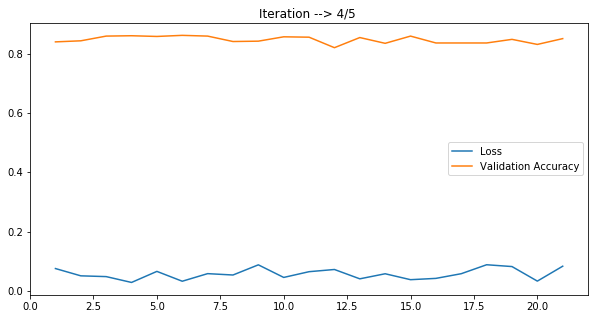

Iteration --> 5/5 
		
Loss :  0.0198	Validation Accuracy :  0.8178
		
Loss :  0.1094	Validation Accuracy :  0.8386
		
Loss :  0.0337	Validation Accuracy :  0.8924
		
Loss :  0.0509	Validation Accuracy :  0.857
		
Loss :  0.0451	Validation Accuracy :  0.8667
		
Loss :  0.0639	Validation Accuracy :  0.8509
		
Loss :  0.0244	Validation Accuracy :  0.8655
		
Loss :  0.0542	Validation Accuracy :  0.8655
		
Loss :  0.0237	Validation Accuracy :  0.8509
		
Loss :  0.0281	Validation Accuracy :  0.868
		
Loss :  0.0277	Validation Accuracy :  0.8509
		
Loss :  0.1691	Validation Accuracy :  0.8521
		
Loss :  0.0477	Validation Accuracy :  0.8386
		
Loss :  0.0746	Validation Accuracy :  0.8362
		
Loss :  0.0501	Validation Accuracy :  0.8521
		
Loss :  0.0758	Validation Accuracy :  0.8594
		
Loss :  0.023	Validation Accuracy :  0.8313
		
Loss :  0.1808	Validation Accuracy :  0.8386
		
Loss :  0.0563	Validation Accuracy :  0.8557
		
Loss :  0.0337	Validation Accuracy :  0.8521
		
Loss :  0.0392	Valida

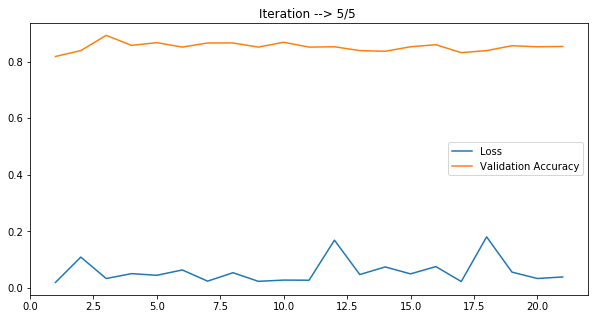

TRAINING OVER!!!!
Training Time:  57.45445728302002  minutes


In [12]:
print("TRAINING STARTED!!!!")
start = time.time()


num_of_iterations = 5
print_every = 5
steps = 0

for i in range(num_of_iterations):
    
    Loss = []
    Validation_accuracy = []
    count = []
    j = 1
    
    
    print("================================================================")
    print("Iteration --> {}/{} ".format(i+1, num_of_iterations), end = '\n')
    print("================================================================")
    
    for inputs, labels in dataloaders_train:
        
        running_loss = 0
        steps += 1
        
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad()
        
        #Feeding forward
        outputs = base_model.forward(inputs)
        loss = criterion(outputs, labels)
        #Back-propagation
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item()
        
        with torch.no_grad():
            if steps % print_every == 0:
                validation_accuracy = check_accuracy(dataloaders_validate)
                print("\t\t")
                print("Loss : ", round((running_loss/print_every), 4), end = '\t')
                print("Validation Accuracy : ", round(validation_accuracy, 4))
                Loss.append(round((running_loss/print_every), 4))
                Validation_accuracy.append(round(validation_accuracy, 4))
                count.append(j)
                j += 1
    print()
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(5)
    plt.plot(count, Loss, label = "Loss")
    plt.plot(count, Validation_accuracy, label = "Validation Accuracy")
    plt.title("Iteration --> {}/{} ".format(i+1, num_of_iterations))
    plt.legend()
    plt.show()
    #torch.cuda.empty_cache()

    
    
    
print("TRAINING OVER!!!!")
end = time.time()
print("Training Time: ", (end - start)/60, " minutes")

In [13]:
ls -lh

total 208K
drwxr-xr-x 2 root root 4.0K Apr  1  2019 assets/
-rw-r--r-- 1 root root 2.2K Mar  5  2018 cat_to_name.json
lrwxrwxrwx 1 root root   21 Oct 13  2018 flowers -> ../../../data/flowers/
-rw-r--r-- 1 root root 168K Mar 24 14:35 Image Classifier Project.ipynb
-rw-r--r-- 1 root root  16K Aug  5  2018 Image Classifier Project-zh.ipynb
-rw-r--r-- 1 root root 1.1K Feb  6  2018 LICENSE
-rw-r--r-- 1 root root    0 Feb  6  2018 predict.py
-rw-r--r-- 1 root root  250 Apr 20  2018 README.md
-rw-r--r-- 1 root root    0 Feb  6  2018 train.py
-rw-r--r-- 1 root root 1.6K Sep 28  2018 workspace-utils.py


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [14]:
# TODO: Do validation on the test set

def test_accuracy(dataloaders):
    return check_accuracy(dataloaders)

ans = test_accuracy(dataloaders_test)
print("Network Accuracy on the Test Dataset = ", round(ans*100, 4), "%")

Network Accuracy on the Test Dataset =  84.4933 %


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [15]:
# TODO: Save the checkpoint 

base_model.class_to_idx = image_datasets_train.class_to_idx

dictionary = {
            'transfer model': 'vgg16',
            'input_size': 25088,
            'output_size': 102,
            'features': base_model.features,
            'classifier': base_model.classifier,
            'optimizer': optimizer.state_dict(),
            'state_dict': base_model.state_dict(),
            'idx_to_class': {v:k for k, v in image_datasets_train.class_to_idx.items()}
            }
torch.save(dictionary, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [16]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(checkpoint_path):
    base_model_info = torch.load(checkpoint_path)
    base_model = vgg16(pretrained = True)
    
    base_model.classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 2048)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(2048, 256)),
                          ('relu', nn.ReLU()),
                          ('fc3', nn.Linear(256, 102)),
                          ('output', nn.LogSoftmax(dim = 1))
                          ]))
    base_model.load_state_dict(base_model_info['state_dict'])
    idx_to_class = base_model_info['idx_to_class']
    return base_model, base_model_info, idx_to_class


base_model, base_model_info, idx_to_class = load_checkpoint('checkpoint.pth')
print(base_model)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [17]:
print(idx_to_class)

{0: '1', 1: '10', 2: '100', 3: '101', 4: '102', 5: '11', 6: '12', 7: '13', 8: '14', 9: '15', 10: '16', 11: '17', 12: '18', 13: '19', 14: '2', 15: '20', 16: '21', 17: '22', 18: '23', 19: '24', 20: '25', 21: '26', 22: '27', 23: '28', 24: '29', 25: '3', 26: '30', 27: '31', 28: '32', 29: '33', 30: '34', 31: '35', 32: '36', 33: '37', 34: '38', 35: '39', 36: '4', 37: '40', 38: '41', 39: '42', 40: '43', 41: '44', 42: '45', 43: '46', 44: '47', 45: '48', 46: '49', 47: '5', 48: '50', 49: '51', 50: '52', 51: '53', 52: '54', 53: '55', 54: '56', 55: '57', 56: '58', 57: '59', 58: '6', 59: '60', 60: '61', 61: '62', 62: '63', 63: '64', 64: '65', 65: '66', 66: '67', 67: '68', 68: '69', 69: '7', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '8', 81: '80', 82: '81', 83: '82', 84: '83', 85: '84', 86: '85', 87: '86', 88: '87', 89: '88', 90: '89', 91: '9', 92: '90', 93: '91', 94: '92', 95: '93', 96: '94', 97: '95', 98: '96', 99: '97', 100: '98', 101:

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [18]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
        
    image = Image.open(image_path)
    image.load()
    
    
    # Step 1 : Resize image
    
    coordinates = list(image.size)
    short_side = min(coordinates)
    short_side_index = coordinates.index(short_side)
    if short_side_index == 0:
        long_side_index = 1
    else:
        long_side_index = 0
    aspect_ratio = coordinates[long_side_index] / coordinates[short_side_index]
    coordinates[short_side_index] = 256
    coordinates[long_side_index] = int(256 * aspect_ratio)
    resized_image = image.resize(coordinates)
    
    
    
    # Step 2 : Crop image
    
    width, height = resized_image.size
    new_width, new_height = 224, 224
    left = (width - new_width)/2
    right = (width + new_width)/2
    top = (height - new_height)/2
    bottom = (height + new_height)/2
    cropped_image = resized_image.crop((left, top, right, bottom))
    
    
    processed_image = np.array(cropped_image)
    
    # convert colour channel from 0-255, to 0-1
    
    processed_image = processed_image.astype('float64')
    processed_image = processed_image / 255
    
    # normalize for model
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    

    processed_image = (processed_image - mean) / std
    #print(processed_image.shape)
    
    
    # tranpose color channge to 1st dim
    processed_image = processed_image.transpose((2, 0, 1))
    
    #print(processed_image.shape)
    return processed_image
    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [19]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

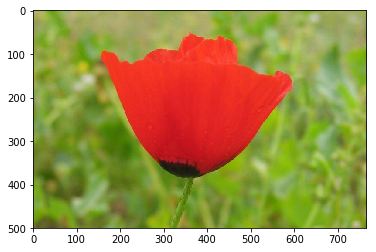

In [20]:
path_string = 'flowers/test/26/image_06526.jpg'
image = Image.open(path_string)
fig, ax = plt.subplots()
ax.imshow(image);

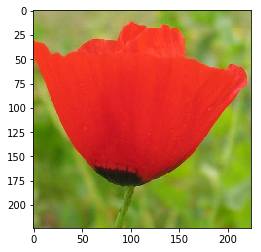

In [21]:
# Trying the process_image function

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
    
processed_image = process_image(path_string)
processed_image = processed_image.transpose((1,2,0))
processed_image = std * processed_image + mean
fig, ax = plt.subplots()
ax.imshow(processed_image);

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [22]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    with torch.no_grad():
        image = process_image(image_path)
        #print(image.shape)
        #print(image)
        image = torch.from_numpy(image)
        image.unsqueeze_(0)
        image = image.float()
        model,_,_ = load_checkpoint(model)
        #print(image.shape)
        #print(image)
        outputs = model(image)
        probabilities, indices = torch.exp(outputs).topk(topk)
        indices = np.array(indices)
        #print(indices)
        top_classes = [int(idx_to_class[x]) for x in indices[0]]
        
        return probabilities[0].tolist(), top_classes

In [23]:
path_string = 'flowers/train/1/image_06772.jpg'
probabilities, classes = predict(path_string, 'checkpoint.pth')

print("Class  Probability")
for i in range(0, len(classes)):
    print(classes[i], "\t", round(probabilities[i],3))

Class  Probability
1 	 0.994
70 	 0.004
26 	 0.001
97 	 0.001
51 	 0.0


In [24]:
path_string = 'flowers/valid/10/image_07094.jpg'
probabilities, classes = predict(path_string, 'checkpoint.pth')

print("Class  Probability")
for i in range(0, len(classes)):
    print(classes[i], "\t", round(probabilities[i],3))

Class  Probability
10 	 1.0
92 	 0.0
14 	 0.0
33 	 0.0
29 	 0.0


In [25]:
path_string = 'flowers/test/12/image_03994.jpg'
probabilities, classes = predict(path_string, 'checkpoint.pth')

print("Class  Probability")
for i in range(0, len(classes)):
    print(classes[i], "\t", round(probabilities[i],3))

Class  Probability
12 	 1.0
50 	 0.0
47 	 0.0
42 	 0.0
48 	 0.0


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [ ]:
# TODO: Display an image along with the top 5 classes

In [26]:
def sanity_check(path_string, model):
    probabilities, classes = predict(path_string, 'checkpoint.pth')
    
    # Finding the actual flower name to be compared with the predicted flower name for checking model performance
    path_list = path_string.split("/")
    ground_truth = cat_to_name[path_list[2]]
    
    
    flower_classes = []
    for ele in classes:
        flower_classes.append(cat_to_name[str(ele)] + "(" + str(ele) + ")")
    image = Image.open(path_string)
    fig, ax = plt.subplots(2, 1, figsize=(3,7))
    ax[0].imshow(image)
    y_positions = list(range(len(flower_classes)))
    
    ax[1].barh(y_positions, probabilities)
    ax[1].set_yticks(y_positions)
    ax[1].set_yticklabels(flower_classes)
    ax[1].set_xlabel('Probability of class (in %)')
    ax[1].invert_yaxis()
    ax[1].set_title('Top 5 Class Predictions')
    #print(flower_classes)
    
    ax[0].set_title("Actual Flower Name = {} ".format(ground_truth))
    
    
    # Finding the predicted flower name
    predicted_flower = cat_to_name[str(classes[0])]
    
    
    # Printing results
    print("Predicted Flower Name = {} ".format(predicted_flower))
    if ground_truth == predicted_flower:
        print("Correct Prediction")
    elif int(path_list[2]) in classes:
        print("Prediction is incorrect but actual flower name lies in the top 5 predictions")
    else:
        print("Incorrect Prediction" )

Predicted Flower Name = pink primrose 
Correct Prediction


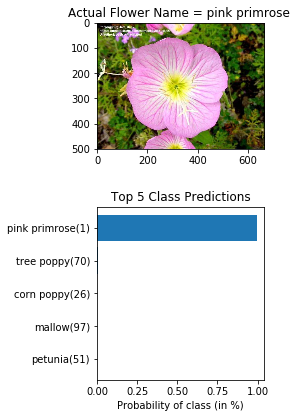

In [27]:
# Sanity Check on train datasets 

path_string = 'flowers/train/1/image_06772.jpg'
checkpoint = 'checkpoint.pth'

sanity_check(path_string, checkpoint)

Predicted Flower Name = orange dahlia 
Correct Prediction


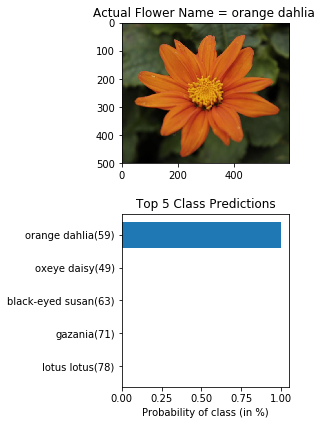

In [29]:
# Sanity Check on test datasets 

path_string = 'flowers/test/59/image_05020.jpg'
checkpoint = 'checkpoint.pth'

sanity_check(path_string, checkpoint)

Predicted Flower Name = wallflower 
Correct Prediction


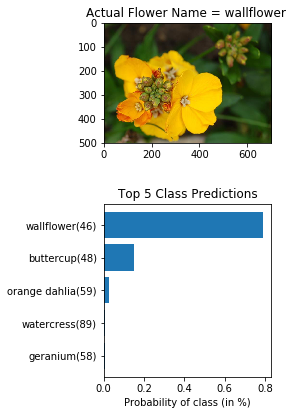

In [30]:
# Sanity Check on test datasets 

path_string = 'flowers/test/46/image_00961.jpg'
checkpoint = 'checkpoint.pth'

sanity_check(path_string, checkpoint)

Predicted Flower Name = garden phlox 
Correct Prediction


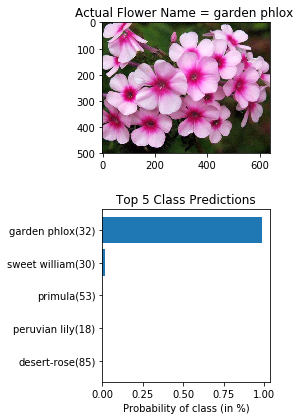

In [31]:
# Sanity Check on test datasets 

path_string = 'flowers/test/32/image_05592.jpg'
checkpoint = 'checkpoint.pth'

sanity_check(path_string, checkpoint)

Predicted Flower Name = hard-leaved pocket orchid 
Correct Prediction


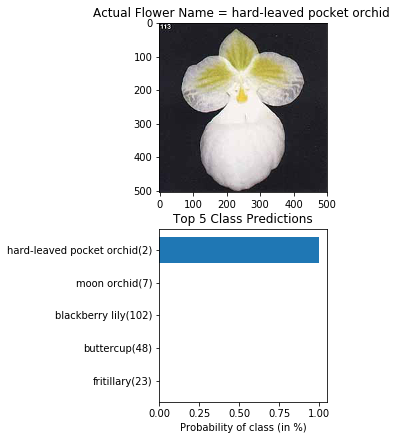

In [32]:
# Sanity Check on test datasets 

path_string = 'flowers/test/2/image_05107.jpg'
checkpoint = 'checkpoint.pth'

sanity_check(path_string, checkpoint)

<font color='red'>**Reminder for Workspace users:** If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.</font>

In [ ]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace

In [33]:
! rm *.pth